In [394]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Model Set-up (Feedforward)

In [395]:
# this function defines sigmoid activation function: f(x) = 1 / (1 + e^(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# this function defines the derivative of sigmoid function, which is used in Backpropagation
def deriv_sigmoid(x):
    fx = sigmoid(x)
    return fx * (1 - fx)

# this function defines the loss function, which follows the paper, using MSE (mean squared error)
def MSE(y_true, y_prediction):
    return ((y_true - y_prediction) ** 2).mean()

In [396]:
# this function initialises the network with the structure of 4 layers
# 1st layer: input  layer, 36 inputs
# 2nd layer: hidden layer, 4 neurons
# 3rd layer: hidden layer, 4 neurons
# 4th layer: output layer, 1 output

def parameters_reset (n1 = 4, n2 = 4) :
    # show that we are changing the global variables
    global W1, W2, W3, b1, b2, b3
    # to keep the initial parameters the same
    np.random.seed(4)
    
    W1 = np.random.randn(n1, 36) / 2 # weights between the inputs and the neurons at the 1st hidden layer
    W2 = np.random.randn(n2, n1) / 2 # weights between the neurons at the 1st hidden and at the 2nd hidden layer
    W3 = np.random.randn(1 , n2) / 2 # weights between the neurons at the 2nd hidden and the output
    
    b1 = np.random.randn(n1, 1 ) / 2 # biases of the neurons at the 1st hidden layer
    b2 = np.random.randn(n2, 1 ) / 2 # biases of the neurons at the 2nd hidden layer
    b3 = np.random.randn(1 , 1 ) / 2 # bias   of the neuron  at the     output layer

parameters_reset (n1 = 4, n2 = 4)

In [397]:
# This function realizes the stage of Feedforward
def network_function(a0,W1,W2,W3,b1,b2,b3) :
    s1 = W1 @ a0 + b1
    a1 = sigmoid(s1) 
    s2 = W2 @ s1 + b2
    a2 = sigmoid(s2)
    s3 = W3 @ s2 + b3
    # a3 = sigmoid(s3)
    # since this is not a classification problem, we do not put activation function on the output layer
    return a0, s1, a1, s2, a2, s3

# Jacobian Matrixes Set-up (Backpropagation)

In [398]:
# Jacobian for the weights of the output layer
def J_W3 (x, y) :
    # dMSE/ da3 = 2 (a3 - y)
    J = 2 * (s3 - y)
    # da3 / ds3 = deriv_sigmoid(s3) # J = J * deriv_sigmoid(s3) # skip
    # ds3 / dW3 = a2, and divide by the number of training examples, for the average over all training examples
    J = J @ a2.T / x.shape[1]
    return J

# Jacobian for the bias of the output layer
def J_b3 (x, y) :
    J = 2 * (s3 - y)
    # J = J * deriv_sigmoid(s3) # skip
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [399]:
# Jacobian for the weights of the 2nd hidden layer
def J_W2 (x, y) :
    # dC  / da3 = 2 (a3 - y)
    J = 2 * (s3 - y)
    # da3 / ds3 = deriv_sigmoid(s3) # J = J * deriv_sigmoid(s3) # skip
    # ds3 / da2 = W3
    J = (J.T @ W3).T
    # da2 / ds2 = deriv_sigmoid(s2)
    J = J * deriv_sigmoid(s2)
    # ds2 / dW2 = a1, and divide by the number of training examples, for the average over all training examples
    J = J @ a1.T / x.shape[1]
    return J

# Jacobian for the biases of the 2nd hidden layer
def J_b2 (x, y) :
    J = 2 * (s3 - y)
    # J = J * deriv_sigmoid(s3) # skip
    J = (J.T @ W3).T
    J = J * deriv_sigmoid(s2)
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [400]:
# Jacobian for the weights of the 1st hidden layer
def J_W1 (x, y) :
    # dC  / da3 = 2 (a3 - y)    
    J = 2 * (s3 - y)
    # da3 / ds3 = deriv_sigmoid(s3) # J = J * deriv_sigmoid(a3) # skip
    # ds3 / da2 = W3    
    J = (J.T @ W3).T
    # da2 / ds2 = deriv_sigmoid(s2)    
    J = J * deriv_sigmoid(a2)
    # ds2 / da1 = W2    
    J = (J.T @ W2).T
    # da1 / ds1 = deriv_sigmoid(s1) 
    J = J * deriv_sigmoid(a1)
    # ds1 / dW1 = a0, and divide by the number of training examples, for the average over all training examples
    J = J @ a0.T / x.shape[1]
    return J    

# Jacobian for the biases of the 1st hidden layer
def J_b1 (x, y) :
    J = 2 * (s3 - y)
    # J = J * deriv_sigmoid(a3) # skip
    J = (J.T @ W3).T
    J = J * deriv_sigmoid(a2)
    J = (J.T @ W2).T
    J = J * deriv_sigmoid(a1)
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

# Mini-batch Algorithm Set-up

In [401]:
# define the function that randomly sorts the data batches (size > 1)
# the import should be dataframe
def batches(X, Y, size, seed):
    # fix this random seed at this moment, will be changed for each iteration
    np.random.seed(seed)
    # number of total instances
    num_instances = X.shape[0]
    # list initialized
    batches_full  = list()
    
    # shuffle X and Y 
    shuf_order = list(np.random.permutation(num_instances))
    shuf_X     = X.iloc[shuf_order,:]
    shuf_Y     = Y.iloc[shuf_order,:]
   
    # get the number of the full batches
    num_batch  = math.floor(num_instances / size)
    
    # get the new sorted batches
    for k in range(num_batch):
        batches_X = shuf_X.iloc[k*size : (k+1)*size-1 ,:]
        batches_Y = shuf_Y.iloc[k*size : (k+1)*size-1 ,:]
        batches   = (batches_X, batches_Y)
        
        batches_full.append(batches)
    
    # get the last remaining batch
    if num_instances % size != 0:
        batches_X = shuf_X.iloc[size*num_batch:,:]
        batches_Y = shuf_Y.iloc[size*num_batch:,:]
        batches   = (batches_X, batches_Y)
        
        batches_full.append(batches)

    return batches_full

# Data Import and Preprocessing

In [402]:
# since the raw data is a 1-dimension data, for the purpose of 
# getting 36 previous unrates as the inputs, and getting 1 current unrate as the output,
# we use sliding window (step = 1) to create the following dataframe
# 1 to 36 are the inputs, and UNRATE is the true value of the output

unrate = pd.read_csv('/Users/shenchen/Desktop/Numerical/Coursework/UNRATE.csv')
for i in range (36):
    unrate.loc[:,i+1] = unrate['UNRATE'].shift(+(36-i))
unrate =  unrate.iloc[36:,:].reset_index() # loose 36 obs
unrate.head()

,index,DATE,UNRATE,1,2,3,4,5,6,7,...,27,28,29,30,31,32,33,34,35,36
0,36,1966-01-01,4.0,5.7,5.9,5.7,5.7,5.9,5.6,5.6,...,4.7,4.8,4.6,4.6,4.4,4.4,4.3,4.2,4.1,4.0
1,37,1966-02-01,3.8,5.9,5.7,5.7,5.9,5.6,5.6,5.4,...,4.8,4.6,4.6,4.4,4.4,4.3,4.2,4.1,4.0,4.0
2,38,1966-03-01,3.8,5.7,5.7,5.9,5.6,5.6,5.4,5.5,...,4.6,4.6,4.4,4.4,4.3,4.2,4.1,4.0,4.0,3.8
3,39,1966-04-01,3.8,5.7,5.9,5.6,5.6,5.4,5.5,5.5,...,4.6,4.4,4.4,4.3,4.2,4.1,4.0,4.0,3.8,3.8
4,40,1966-05-01,3.9,5.9,5.6,5.6,5.4,5.5,5.5,5.7,...,4.4,4.4,4.3,4.2,4.1,4.0,4.0,3.8,3.8,3.8


# (Batch) Gradient Descent

Iteration 0 loss: 65.038
Iteration 1 loss: 4.979
Iteration 2 loss: 4.461
Iteration 3 loss: 4.376
Iteration 4 loss: 4.321
Iteration 5 loss: 4.265
Iteration 6 loss: 4.210
Iteration 7 loss: 4.155
Iteration 8 loss: 4.101
Iteration 9 loss: 4.048
Iteration 10 loss: 3.996
Iteration 11 loss: 3.944
Iteration 12 loss: 3.893
Iteration 13 loss: 3.843
Iteration 14 loss: 3.793
Iteration 15 loss: 3.744
Iteration 16 loss: 3.696
Iteration 17 loss: 3.649
Iteration 18 loss: 3.602
Iteration 19 loss: 3.556
Iteration 20 loss: 3.510
Iteration 21 loss: 3.465
Iteration 22 loss: 3.421
Iteration 23 loss: 3.377
Iteration 24 loss: 3.334
Iteration 25 loss: 3.292
Iteration 26 loss: 3.250
Iteration 27 loss: 3.208
Iteration 28 loss: 3.168
Iteration 29 loss: 3.127
Iteration 30 loss: 3.088
Iteration 31 loss: 3.049
Iteration 32 loss: 3.010
Iteration 33 loss: 2.972
Iteration 34 loss: 2.935
Iteration 35 loss: 2.898
Iteration 36 loss: 2.862
Iteration 37 loss: 2.826
Iteration 38 loss: 2.791
Iteration 39 loss: 2.756
Iteration

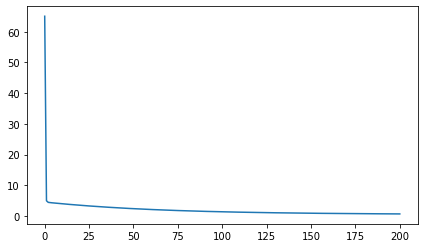

In [415]:
# (Batch) Gradient Descent

# parameters setting
learn_rate      = 0.01
total_iteration = 200

# dataset
x  = np.array(unrate.iloc[:,3:].T)
y  = np.array(unrate[['UNRATE']].T)

# parameters reset and feedforeward
parameters_reset (n1 = 4, n2 = 4)
a0, s1, a1, s2, a2, s3 = network_function(x,W1,W2,W3,b1,b2,b3)

# create a list to keep the loss
Los_GD          = list()

# initial loss
Loss = MSE(y, s3)
Los_GD.append(Loss)
print("Iteration %d loss: %.3f" % (0, Loss))

for iteration_number in range(1,total_iteration+1): 
    W1 -= learn_rate * J_W1 (x, y)
    W2 -= learn_rate * J_W2 (x, y)
    W3 -= learn_rate * J_W3 (x, y)
    b1 -= learn_rate * J_b1 (x, y)
    b2 -= learn_rate * J_b2 (x, y)
    b3 -= learn_rate * J_b3 (x, y)
    a0, s1, a1, s2, a2, s3 = network_function(x,W1,W2,W3,b1,b2,b3)
    
    Loss = MSE(y, s3)
    Los_GD.append(Loss)
    print("Iteration %d loss: %.3f" % (iteration_number, Loss))

# plot the diagram of iteration and lossfuntion
plt.figure(figsize= (7,4))
plt.plot(range(201), Los_GD)

# Stochastic Gradient Descent

Iteration 0 loss: 65.038
Iteration 1 loss: 0.394
Iteration 2 loss: 0.241
Iteration 3 loss: 0.321
Iteration 4 loss: 0.182
Iteration 5 loss: 0.193
Iteration 6 loss: 0.142
Iteration 7 loss: 0.152
Iteration 8 loss: 0.177
Iteration 9 loss: 0.175
Iteration 10 loss: 0.134
Iteration 11 loss: 0.138
Iteration 12 loss: 0.142
Iteration 13 loss: 0.143
Iteration 14 loss: 0.132
Iteration 15 loss: 0.130
Iteration 16 loss: 0.133
Iteration 17 loss: 0.121
Iteration 18 loss: 0.123
Iteration 19 loss: 0.130
Iteration 20 loss: 0.130
Iteration 21 loss: 0.164
Iteration 22 loss: 0.111
Iteration 23 loss: 0.114
Iteration 24 loss: 0.127
Iteration 25 loss: 0.130
Iteration 26 loss: 0.206
Iteration 27 loss: 0.093
Iteration 28 loss: 0.093
Iteration 29 loss: 0.096
Iteration 30 loss: 0.144
Iteration 31 loss: 0.097
Iteration 32 loss: 0.145
Iteration 33 loss: 0.080
Iteration 34 loss: 0.081
Iteration 35 loss: 0.083
Iteration 36 loss: 0.152
Iteration 37 loss: 0.119
Iteration 38 loss: 0.115
Iteration 39 loss: 0.176
Iteration

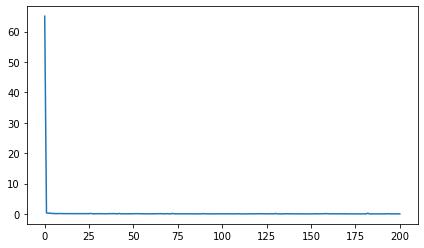

In [416]:
# Stochastic Gradient Descent

# parameters setting
learn_rate      = 0.01
total_iteration = 200

# dataset
x  = np.array(unrate.iloc[:,3:].T)
y  = np.array(unrate[['UNRATE']].T)

# parameters reset and feedforeward
parameters_reset (n1 = 4, n2 = 4)
a0, s1, a1, s2, a2, s3 = network_function(x,W1,W2,W3,b1,b2,b3)

# reset dataset
X  = unrate.iloc[:,3:]
Y  = unrate[['UNRATE']]

# create a list to keep the loss
Los_SGD         = list()

# initial loss
Loss = MSE(y, s3)
Los_SGD.append(Loss)
print("Iteration %d loss: %.3f" % (0, Loss))


for iteration_number in range(1,total_iteration+1): 
    for i in list(np.random.permutation(x.shape[1])):
        A0, S1, A1, S2, A2, S3 = network_function(x,W1,W2,W3,b1,b2,b3)
        a0 = A0.T[i].reshape(36,1)
        s1 = S1.T[i].reshape(4 ,1)
        a1 = A1.T[i].reshape(4 ,1)
        s2 = S2.T[i].reshape(4 ,1)
        a2 = A2.T[i].reshape(4 ,1)
        s3 = S3.T[i].reshape(1 ,1)
        W1 -= learn_rate * J_W1 (a0, y[0][i])
        W2 -= learn_rate * J_W2 (a0, y[0][i])
        W3 -= learn_rate * J_W3 (a0, y[0][i])
        b1 -= learn_rate * J_b1 (a0, y[0][i])
        b2 -= learn_rate * J_b2 (a0, y[0][i])
        b3 -= learn_rate * J_b3 (a0, y[0][i])
    a0, s1, a1, s2, a2, s3 = network_function(x,W1,W2,W3,b1,b2,b3)
    Loss = MSE(y, s3)
    Los_SGD.append(Loss)
    print("Iteration %d loss: %.3f" % (iteration_number, Loss))

# plot the diagram of iteration and lossfuntion
plt.figure(figsize= (7,4))
plt.plot(range(201), Los_SGD)

# Mini-batch Stochastic Gradient Descent

Iteration 0 loss: 65.038
Iteration 1 loss: 2.955
Iteration 2 loss: 1.689
Iteration 3 loss: 1.241
Iteration 4 loss: 0.925
Iteration 5 loss: 0.824
Iteration 6 loss: 1.215
Iteration 7 loss: 0.594
Iteration 8 loss: 0.613
Iteration 9 loss: 0.485
Iteration 10 loss: 0.460
Iteration 11 loss: 0.719
Iteration 12 loss: 0.516
Iteration 13 loss: 0.430
Iteration 14 loss: 0.472
Iteration 15 loss: 0.484
Iteration 16 loss: 0.380
Iteration 17 loss: 0.605
Iteration 18 loss: 0.393
Iteration 19 loss: 0.346
Iteration 20 loss: 0.401
Iteration 21 loss: 0.360
Iteration 22 loss: 0.338
Iteration 23 loss: 0.335
Iteration 24 loss: 0.311
Iteration 25 loss: 0.350
Iteration 26 loss: 0.356
Iteration 27 loss: 0.359
Iteration 28 loss: 0.323
Iteration 29 loss: 0.283
Iteration 30 loss: 0.279
Iteration 31 loss: 0.290
Iteration 32 loss: 0.315
Iteration 33 loss: 0.277
Iteration 34 loss: 0.571
Iteration 35 loss: 0.299
Iteration 36 loss: 0.261
Iteration 37 loss: 0.247
Iteration 38 loss: 0.290
Iteration 39 loss: 0.241
Iteration

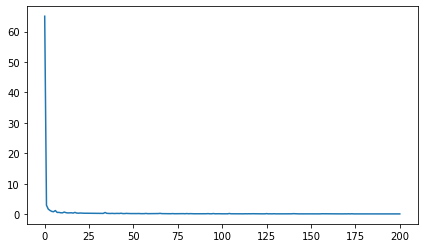

In [417]:
# Mini-batch Stochastic Gradient Descent

# parameters setting
learn_rate      = 0.01
total_iteration = 200
siz = 16
see = 0

# dataset
x  = np.array(unrate.iloc[:,3:].T)
y  = np.array(unrate[['UNRATE']].T)

# parameters reset and feedforeward
parameters_reset (n1 = 4, n2 = 4)
a0, s1, a1, s2, a2, s3 = network_function(x,W1,W2,W3,b1,b2,b3)

# create a list to keep the loss
Los_MBSGD       = list()

# initial loss
Loss = MSE(y, s3)
Los_MBSGD.append(Loss)
print("Iteration %d loss: %.3f" % (0, Loss))

# reset dataset
X  = unrate.iloc[:,3:]
Y  = unrate[['UNRATE']]

for iteration_number in range(1,total_iteration+1): 
    for Batch in batches(X, Y, size = siz, seed = see):
        (Batch_X, Batch_Y) = Batch
        Batch_X = np.array(Batch_X).T
        Batch_Y = np.array(Batch_Y).T
        a0, s1, a1, s2, a2, s3 = network_function(Batch_X,W1,W2,W3,b1,b2,b3)
        W1 -= learn_rate * J_W1 (a0, Batch_Y)
        W2 -= learn_rate * J_W2 (a0, Batch_Y)
        W3 -= learn_rate * J_W3 (a0, Batch_Y)
        b1 -= learn_rate * J_b1 (a0, Batch_Y)
        b2 -= learn_rate * J_b2 (a0, Batch_Y)
        b3 -= learn_rate * J_b3 (a0, Batch_Y)
    see += 1
    a0, s1, a1, s2, a2, s3 = network_function(x,W1,W2,W3,b1,b2,b3)
    Loss = MSE(y, s3)
    Los_MBSGD.append(Loss)
    print("Iteration %d loss: %.3f" % (iteration_number, Loss))

# plot the diagram of iteration and lossfuntion
plt.figure(figsize= (7,4))
plt.plot(range(201), Los_MBSGD)

# Comparison among the algorithms

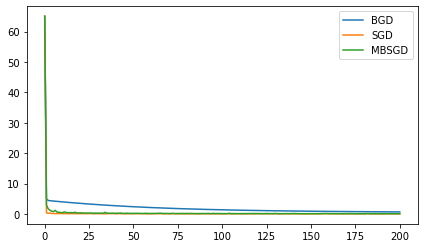

In [419]:
# whole training process
plt.figure(figsize= (7,4))
plt.plot(range(201), Los_GD)
plt.plot(range(201), Los_SGD)
plt.plot(range(201), Los_MBSGD)
plt.legend(['BGD', 'SGD', 'MBSGD'], loc='upper right')
plt.show()

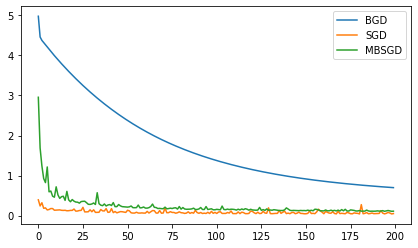

In [420]:
# to see the fluctuations, we ignore the initial value
plt.figure(figsize= (7,4))
plt.plot(range(200), Los_GD[1:])
plt.plot(range(200), Los_SGD[1:])
plt.plot(range(200), Los_MBSGD[1:])
plt.legend(['BGD', 'SGD', 'MBSGD'], loc='upper right')
plt.show()